In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm

In [2]:
print(torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

False
cpu


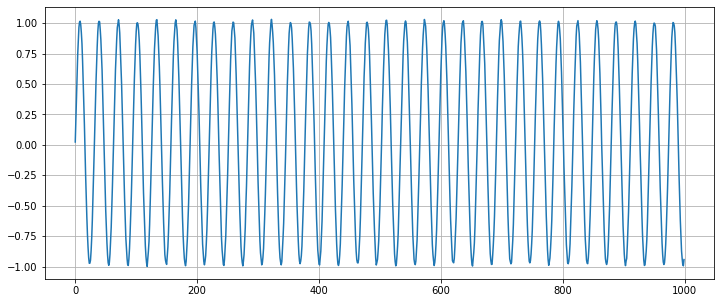

In [3]:
np.random.seed(123)
w1 = np.linspace(0, 999, 1000)
wave1 = np.sin(w1*2*5/50)+(np.random.rand(1000)/30)
plt.figure(figsize=(12, 5))
plt.grid(True)
plt.plot(wave1)
plt.show()

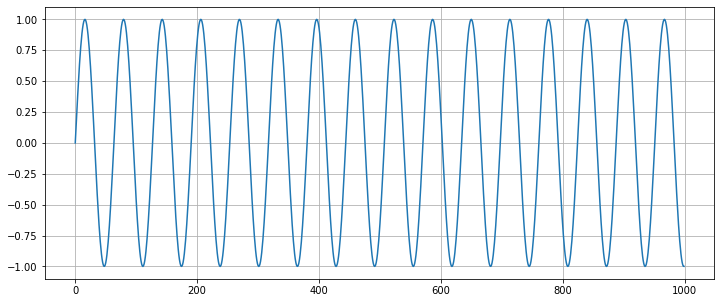

In [4]:
np.random.seed(123)
w2 = np.linspace(0, 99, 1000)
wave2 = np.sin(w2*2*5/10)
plt.figure(figsize=(12, 5))
plt.grid(True)
plt.plot(wave2)
plt.show()

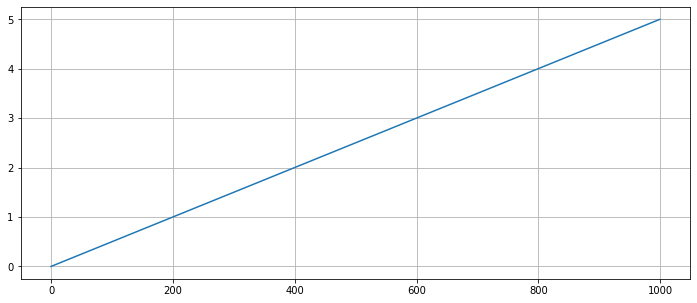

In [5]:
straight_a = np.linspace(0, 5, 1000)
plt.figure(figsize=(12, 5))
plt.grid(True)
plt.plot(straight_a)
plt.show()

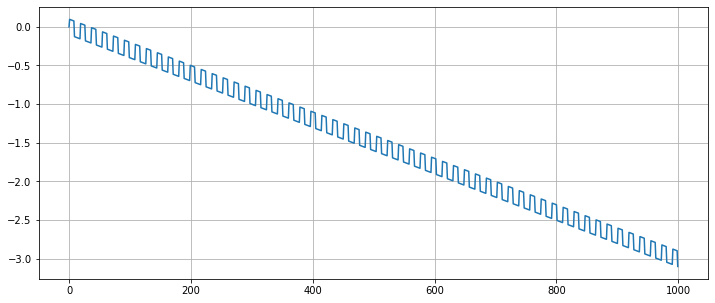

In [6]:
pack = []
j = 0
for i in range(1000):
    if i % 9 == 0:
        if i % 2 == 0:
            pack.append(j)
            j =+ 0.1
        else:
            j =- 0.1
            pack.append(j)
    else:
        pack.append(j)

pack_array = np.array(pack)

straight_b = np.linspace(0, -3, 1000)
straight_pack = straight_b + pack_array
plt.figure(figsize=(12, 5))
plt.grid(True)
plt.plot(straight_pack)
plt.show()

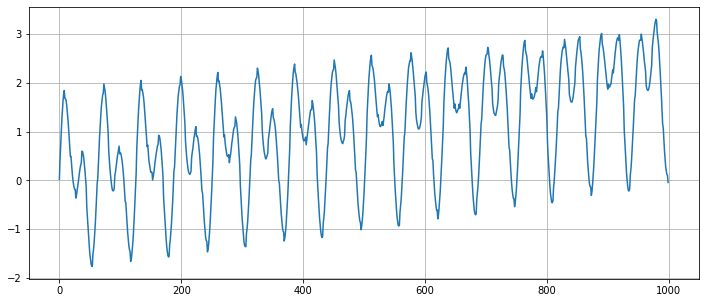

In [7]:
wave = wave1 + wave2 + straight_a + straight_pack
plt.figure(figsize=(12, 5))
plt.grid(True)
plt.plot(wave)
plt.show()

In [8]:
#学習用と検証用に分ける
train_wave1, test_wave1 = train_test_split(wave1, test_size = 0.1, shuffle=False)
train_wave2, test_wave2 = train_test_split(wave2, test_size = 0.1, shuffle=False)
train_straight_a, test_straight_a = train_test_split(straight_a, test_size = 0.1, shuffle=False)
train_straight_pack, test_straight_pack = train_test_split(straight_pack, test_size = 0.1, shuffle=False)
train_wave, test_wave = train_test_split(wave, test_size = 0.1, shuffle=False)

In [9]:
#正規化を行う関数
def minmax(array_data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    #1次元のnumpy_arrayを2次元に変更
    array_data_2d = array_data.reshape(-1,1)
    #下限-1, 上限1 の間に調整する
    minmax_data_2d = scaler.fit_transform(array_data_2d)
    #2次元のnumpy_arrayを1次元にする
    #minmax_data = minmax_data_2d.reshape(-1)
    return minmax_data_2d, scaler

In [10]:
train_wave1_scaled, wave1_scaler = minmax(train_wave1)
train_wave2_scaled, wave2_scaler = minmax(train_wave2)
train_straight_a_scaled, straight_a_scaler = minmax(train_straight_a)
train_straight_pack_scaled, straight_pack_scaler = minmax(train_straight_pack)
train_wave_scaled, wave_scaler = minmax(train_wave)

train_dataset = np.concatenate((train_wave1_scaled, train_wave2_scaled, train_straight_a_scaled, train_straight_pack_scaled, train_wave_scaled), axis=1) 

In [11]:
train_dataset.shape

(900, 5)

In [12]:
def sequence_creator(input_data, window):
    dataset = []
    data_len = len(input_data)
    
    for i in range(data_len-window):
        #window_frは複数の特徴を一つに纏める為、2次元となるが、labelは1次元にする
        window_fr = input_data[i:i+window]
        label = input_data[i+window:i+window+1].reshape(-1)
        dataset.append((window_fr, label))
    
    return dataset

In [13]:
window_size = 50
train_set = sequence_creator(train_dataset, window_size)

In [14]:
class LSTM(nn.Module):
    
    def __init__(self, input_size=5, hidden_layer_size=32, output_size=5):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, output_size, batch_first=True)

        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        batch_size, seq_len, feature_size = input_seq.shape[0], input_seq.shape[1], input_seq.shape[2]
        # batch_first=Trueとしている為、入力サイズは（バッチサイズ、シーケンスサイズ、特徴量次元数）
        lstm_out, _ = self.lstm(input_seq.reshape(-1, seq_len, feature_size))
        predictions = self.linear(lstm_out[:, -1].reshape(batch_size, -1))
        return predictions

In [15]:
# class LSTM_2(nn.Module):
    
#     def __init__(self, input_size=3, hidden_layer_size=32, output_size=3, num_layers=3):
#         super().__init__()
#         self.hidden_layer_size = hidden_layer_size
        
#         self.lstm = nn.LSTM(input_size, hidden_layer_size, output_size, batch_first=True)
#         self.linear = nn.Linear(hidden_layer_size, output_size)
        

#     def forward(self, input_seq):
#         batch_size, seq_len, feature_size = input_seq.shape[0], input_seq.shape[1], input_seq.shape[2]
#         # batch_first=Trueとしている為、入力サイズは（バッチサイズ、シーケンスサイズ、特徴量次元数）
#         lstm_out, _ = self.lstm1(input_seq.reshape(-1, seq_len, feature_size))
#         predictions = self.linear(lstm_out[:, -1].reshape(batch_size, -1))
#         return predictions

In [16]:
epochs = 20
batch_size = 32

In [17]:
dataloader = DataLoader(train_set, batch_size, drop_last=False)
torch.manual_seed(123)
model = LSTM(input_size=5, output_size=5)
model.to(device)
model.train()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [18]:
loss = []
for i in tqdm(range(epochs)):
    train_loss = 0
    for _, tup in enumerate(dataloader):
        X, y = tup
        X = X.float().to(device)
        y = y.float().to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        
        single_loss = loss_function(y_pred, y)
        single_loss.backward()
        optimizer.step()
        train_loss += single_loss.detach().item()
        
    train_loss /= len(dataloader)
    loss.append(train_loss)
    if (i+1) % 5 == 0:
        print(f'epoch: {i+1} Loss: {train_loss}')

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 5 Loss: 0.28848343811653276
epoch: 10 Loss: 0.15895951097762143
epoch: 15 Loss: 0.042971730370212485
epoch: 20 Loss: 0.02692818445050054


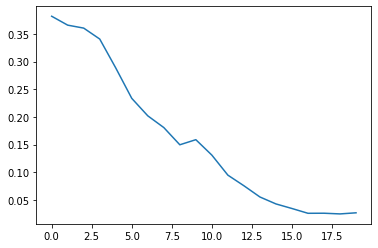

In [19]:
plt.plot(loss)

In [20]:
#検証時に予測の元となるデータサイズ
xx = 100
#検証用の元データ
train_wave1_xx_scaled, train_wave1_xx_scaler = minmax(train_wave1[-xx:])
train_wave2_xx_scaled, train_wave2_xx_scaler = minmax(train_wave2[-xx:])
train_straight_a_xx_scaled, train_straight_a_xx_scaler = minmax(train_straight_a[-xx:])
train_straight_pack_xx_scaled, train_straight_pack_xx_scaler = minmax(train_straight_pack[-xx:])
train_wave_xx_scaled, train_wave_xx_scaler = minmax(train_wave[-xx:])

predictions_set = np.concatenate((train_wave1_xx_scaled, train_wave2_xx_scaled,
                                  train_straight_a_xx_scaled, train_straight_pack_xx_scaled,
                                  train_wave_xx_scaled), axis=1)
#２次元の為、３次元にする(batch_sizeの分)
predictions_set_3d = predictions_set.reshape(1, xx, predictions_set.shape[1])

In [21]:
predictions_set_3d.shape

(1, 100, 5)

In [22]:
model.eval()
test_size = len(test_wave)

In [23]:
for i in range(test_size):
    sequence_in = torch.FloatTensor(predictions_set_3d[:,-xx:]).to(device)
    
    with torch.no_grad():
        pred = model(sequence_in).to('cpu').numpy()[0]
        predictions_set_3d = np.append(predictions_set_3d, pred.reshape(1,1,5), axis=1) 

In [24]:
wave1_pred, wave2_pred, straight_a_pred, straight_pack_pred, wave_pred = np.split(predictions_set_3d, 5, axis=2)

In [25]:
wave_pred.shape

(1, 200, 1)

In [26]:
wave_pred.reshape(-1, 1).shape

(200, 1)

In [27]:
wavw_inverse = train_wave_xx_scaler.inverse_transform(wave_pred.reshape(-1, 1))

In [28]:
wavw_inverse

array([[ 1.26004215],
       [ 0.79967343],
       [ 0.5220767 ],
       [ 0.30532057],
       [ 0.0864451 ],
       [-0.11657969],
       [-0.27937456],
       [-0.36605758],
       [-0.45048707],
       [-0.4553936 ],
       [-0.42111209],
       [-0.14653307],
       [-0.02519027],
       [ 0.17148545],
       [ 0.34883645],
       [ 0.59993845],
       [ 0.85010796],
       [ 1.12514654],
       [ 1.42053153],
       [ 1.47904364],
       [ 1.73145735],
       [ 1.97738475],
       [ 2.21516729],
       [ 2.4025386 ],
       [ 2.52592017],
       [ 2.64723905],
       [ 2.69465236],
       [ 2.74311776],
       [ 2.72168008],
       [ 2.89229048],
       [ 2.79567956],
       [ 2.71571767],
       [ 2.58210839],
       [ 2.44698218],
       [ 2.32325544],
       [ 2.17988313],
       [ 2.05945556],
       [ 1.75511097],
       [ 1.69909522],
       [ 1.62790823],
       [ 1.60952207],
       [ 1.60320037],
       [ 1.63970178],
       [ 1.70044992],
       [ 1.79959737],
       [ 1

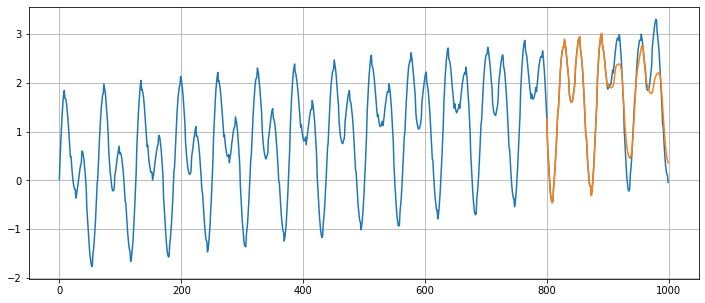

In [29]:
plt.figure(figsize=(12,5))
plt.grid(True)
plt.plot(wave)
plt.plot(range(len(wave)-len(wavw_inverse), len(wave)), wavw_inverse)
plt.show()